In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [3]:
pwd

'/content'

In [4]:
%cd /mydrive/TensorObj_Custom

/content/gdrive/My Drive/TensorObj_Custom


In [4]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [179]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [180]:
# Assigning class names
class_names = ['pistol', 'car', 'bike']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (640, 480)

In [ ]:
# Loading the Data Define a load_data function that load the images and the labels from the folder.

In [181]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images
    """

    datasets = ['./seg_train/train', './seg_test/test']
    output = []

    # Iterate training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the imgage
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output


In [182]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./seg_train/train


100%|██████████| 250/250 [00:02<00:00, 109.65it/s]


Loading ./seg_test/test


100%|██████████| 83/83 [00:00<00:00, 111.72it/s]


In [183]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


**Exploring the data set**
No of training and testing examples Size of each image and proportion of each observed category

In [184]:
import numpy as np

train_labels = np.array(train_labels)
n_train = len(train_labels)
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 709
Number of testing examples: 236
Each image is of size: (640, 480)


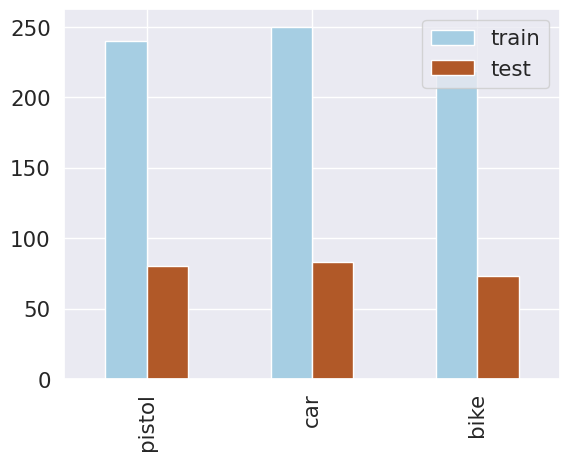

In [185]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar(colormap="Paired")
plt.show()


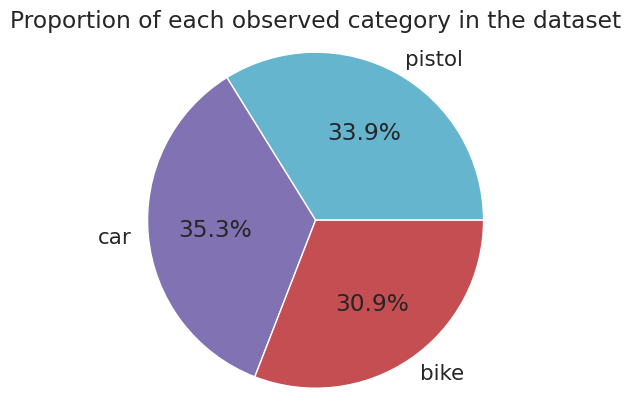

In [186]:
import matplotlib.pyplot as plt
colors=['c','m','r']
plt.pie(train_counts,
        explode=(0, 0, 0) ,
        labels=class_names,colors=colors,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category in the dataset')
plt.show()

**scale the data**

In [187]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [188]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()


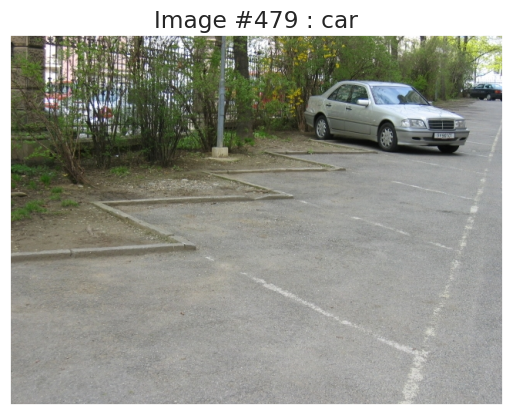

In [190]:
display_random_image(class_names, train_images, train_labels)

To get a better view display the first 25 images from the training set directly with a loop

In [191]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the datasets", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()


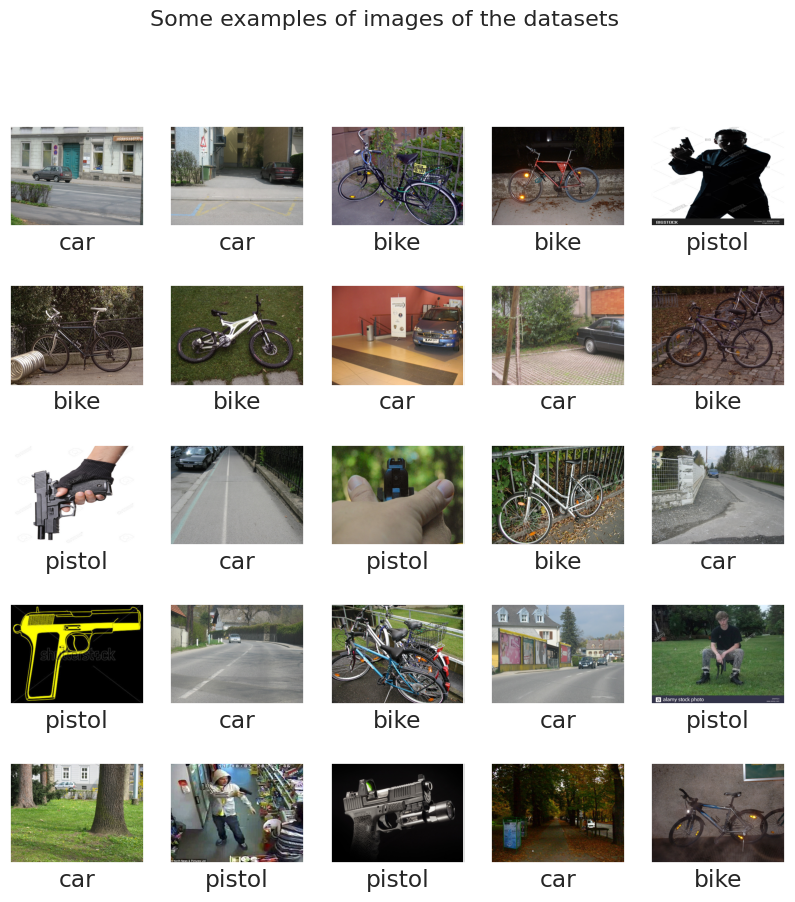

In [192]:
display_examples(class_names, train_images, train_labels)



---**Model Creation**
Steps are:

1. Model Building,
2. Model Compiling,
3. Train / fit the data to the model,
4. Evaluate the model on the testing set,
5. Error analysis of our model.


Layers: Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image. MaxPooling2D: The images get half sized. Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values. Relu : given a value x, returns max(x, 0). Softmax: 6 neurons, probability that the image belongs to one of the classes.



In [193]:
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (480, 640, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then compile it with some parameters such as: Optimizer: adam = RMSProp + Momentum. Momentum = takes into account past gradient to have a better update. RMSProp = exponentially weighted average of the squares of past gradients. Loss function: use sparse categorical crossentropy for classification, each images belongs to one class only

In [194]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category

In [195]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
5/5 [==============================] - 3s 288ms/step - loss: 45.2502 - accuracy: 0.2910 - val_loss: 51.4453 - val_accuracy: 0.3169
Epoch 2/10
5/5 [==============================] - 1s 173ms/step - loss: 25.9913 - accuracy: 0.3457 - val_loss: 14.9461 - val_accuracy: 0.4225
Epoch 3/10
5/5 [==============================] - 1s 169ms/step - loss: 11.5401 - accuracy: 0.4250 - val_loss: 4.9726 - val_accuracy: 0.5563
Epoch 4/10
5/5 [==============================] - 1s 167ms/step - loss: 4.9172 - accuracy: 0.5785 - val_loss: 3.5476 - val_accuracy: 0.6268
Epoch 5/10
5/5 [==============================] - 1s 167ms/step - loss: 1.9299 - accuracy: 0.6949 - val_loss: 2.6325 - val_accuracy: 0.5070
Epoch 6/10
5/5 [==============================] - 1s 168ms/step - loss: 1.2088 - accuracy: 0.7019 - val_loss: 1.5673 - val_accuracy: 0.6831
Epoch 7/10
5/5 [==============================] - 1s 171ms/step - loss: 0.7061 - accuracy: 0.8360 - val_loss: 1.1355 - val_accuracy: 0.6761
Epoch 8/10
5/5 

In [196]:
# Specify the input shape of your model
input_shape = (480, 640, 3)
model.build(input_shape)
# Specify the file path to save the model
model_path = '/content/gdrive/MyDrive/TensorObj_Custom/model'

# Save the model
model.save(model_path)

print("Model saved successfully.")

Model saved successfully.


In [197]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

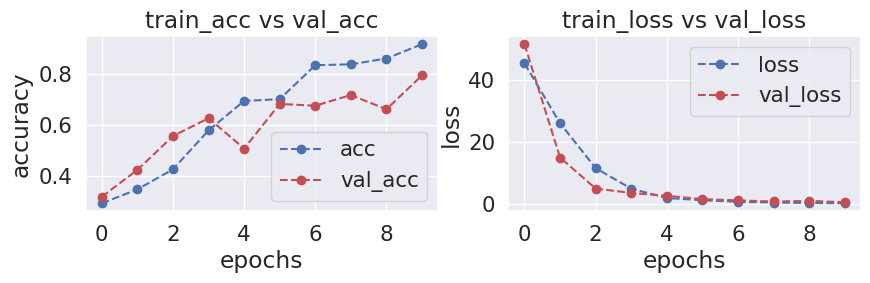

In [198]:
plot_accuracy_loss(history)

Evaluate the model performance on test set


In [199]:
test_loss = model.evaluate(test_images, test_labels)

8/8 [==============================] - 0s 27ms/step - loss: 0.6125 - accuracy: 0.7924


8/8 [==============================] - 0s 26ms/step


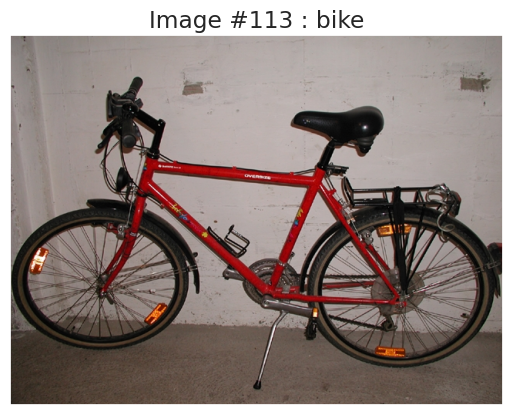

In [202]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

Try to understand on which kind of images the classifier has trouble.

In [203]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


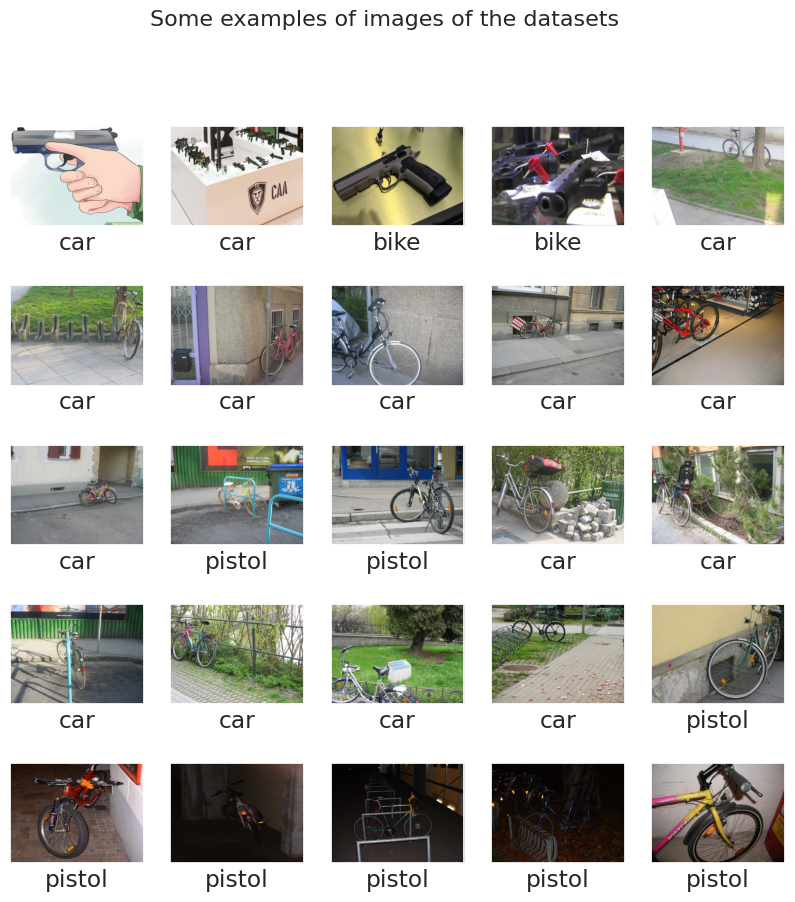

In [204]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

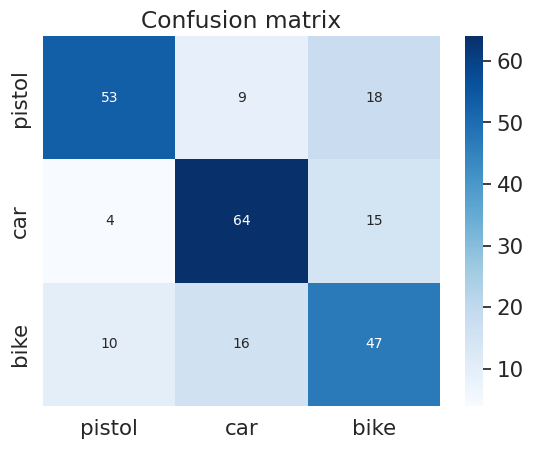

In [122]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,cmap="Blues",fmt='g',
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

**Feature extraction with VGG ImageNet**

In [123]:
# Extract features from VGG16.
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [124]:
# Get the features directly from VGG16
train_features = model.predict(train_images)
test_features = model.predict(test_images)

8/8 [==============================] - 1s 115ms/step


**Visualize the features through PCA**

In [125]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [126]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

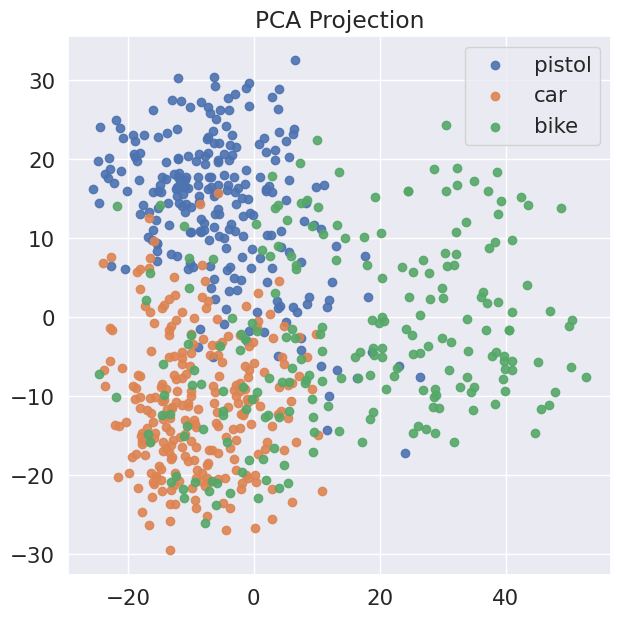

In [127]:
### Figures

plt.subplots(figsize=(7,7))
for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.9)
plt.legend()
plt.title("PCA Projection")
plt.show()

**Training on top of VGG**
Train a simple one-layer Neural Network on the features extracted from VGG

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

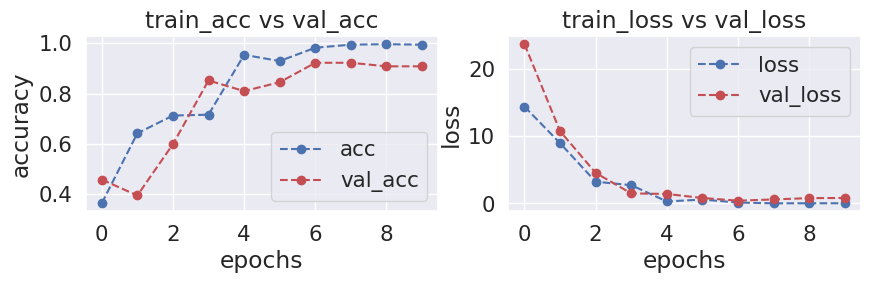

In [129]:
plot_accuracy_loss(history2)

In [130]:
test_loss = model2.evaluate(test_features, test_labels)

8/8 [==============================] - 0s 6ms/step - loss: 0.4424 - accuracy: 0.9449


**Ensemble Neural Networks**

In [131]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [132]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):

    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    # Store model
    models.append(model)

In [133]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
4/4 [==============================] - 1s 89ms/step - loss: 13.4670 - accuracy: 0.3980 - val_loss: 23.0080 - val_accuracy: 0.5439
Epoch 2/10
4/4 [==============================] - 0s 38ms/step - loss: 13.8565 - accuracy: 0.6510 - val_loss: 0.6216 - val_accuracy: 0.8947
Epoch 3/10
4/4 [==============================] - 0s 41ms/step - loss: 5.0979 - accuracy: 0.5941 - val_loss: 1.0913 - val_accuracy: 0.8596
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 1.7199 - accuracy: 0.8471 - val_loss: 3.3292 - val_accuracy: 0.5789
Epoch 5/10
4/4 [==============================] - 0s 37ms/step - loss: 1.8126 - accuracy: 0.8314 - val_loss: 0.0479 - val_accuracy: 0.9825
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 0.2492 - accuracy: 0.9588 - val_loss: 1.2992 - val_accuracy: 0.8596
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 0.6459 - accuracy: 0.9353 - val_loss: 0.6253 - val_accuracy: 0.9123
Epoch 8/10
4/4 [========

Aggregate each model individual predictions to form a final prediction.

In [134]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))

predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

8/8 [==============================] - 0s 6ms/step


In [135]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.940677966101695


**Fine Tuning VGG ImageNet**

In [136]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [137]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

8/8 [==============================] - 1s 110ms/step


In [138]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [139]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [140]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 64)         0   

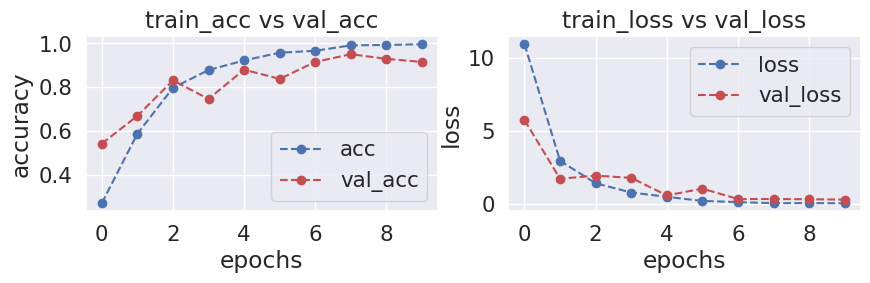

In [58]:
plot_accuracy_loss(history2)

In [212]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [213]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/TensorObj_Custom/model')

In [214]:
def display_random_image(class_names, images, label):
    plt.imshow(images)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image : ' + class_names[label])
    plt.show()

1/1 [==============================] - 0s 22ms/step
Predicted Label: 1
Confidence Score: 67.72%


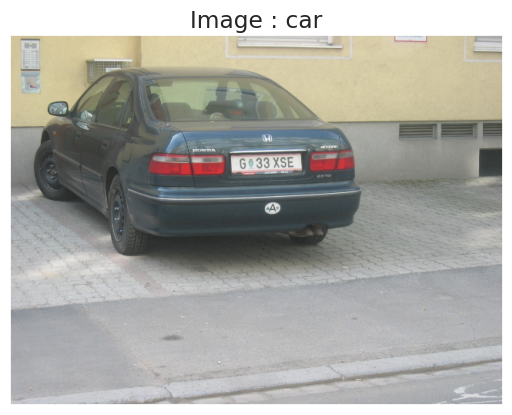

In [239]:
import numpy as np
from PIL import Image

# Load the image
image = Image.open('/content/gdrive/MyDrive/TensorObj_Custom/prediction/001.jpg')

# Preprocess the image
image = image.resize((640, 480))  # Resize the image to match the model's input size
image = np.array(image) / 255.0  # Normalize the pixel values

# Expand dimensions to create a batch of size 1
image = np.expand_dims(image, axis=0)



# Make predictions
predictions = model.predict(image)
pred_label = np.argmax(predictions, axis=1)[0]

print("Predicted Label:", pred_label)
predicted_probabilities = predictions[0]  # Retrieve the predicted probabilities for the image

# Assuming you have the predicted label stored in a variable called 'pred_label'
confidence_score = predicted_probabilities[pred_label]  # Retrieve the confidence score for the predicted label

print("Confidence Score: {:.2f}%".format(confidence_score * 100))

# Display the results
#display_random_image(class_names, image[0], pred_labels)


display_random_image(class_names, image[0], pred_label)



1/1 [==============================] - 0s 22ms/step
Predicted Label: 2
Confidence Score: 75.79%


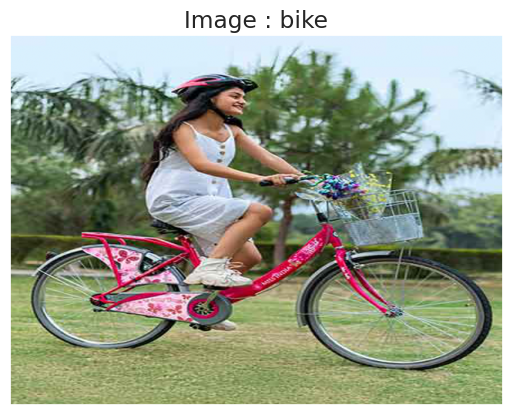

In [240]:
import numpy as np
from PIL import Image

# Load the image
image = Image.open('/content/gdrive/MyDrive/TensorObj_Custom/prediction/bikeper.jpg')

# Preprocess the image
image = image.resize((640, 480))  # Resize the image to match the model's input size
image = np.array(image) / 255.0  # Normalize the pixel values

# Expand dimensions to create a batch of size 1
image = np.expand_dims(image, axis=0)



# Make predictions
predictions = model.predict(image)
pred_label = np.argmax(predictions, axis=1)[0]

print("Predicted Label:", pred_label)
predicted_probabilities = predictions[0]  # Retrieve the predicted probabilities for the image

# Assuming you have the predicted label stored in a variable called 'pred_label'
confidence_score = predicted_probabilities[pred_label]  # Retrieve the confidence score for the predicted label

print("Confidence Score: {:.2f}%".format(confidence_score * 100))

# Display the results
#display_random_image(class_names, image[0], pred_labels)


display_random_image(class_names, image[0], pred_label)
